In [14]:
# If running notebook on brainlife, use ! due to version issues
# !pip install llvmlite --ignore-installed # added due to issue with (un)installing correct version
# !pip install git+https://github.com/JulioAPeraza/gradec.git

In [ ]:
import itertools
import os.path as op
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from gradec.decode import LDADecoder
from gradec.utils import _rm_medial_wall, _decoding_filter
from gradec.plot import plot_surf_maps, plot_radar, plot_cloud
from gradec.fetcher import _fetch_features, _fetch_frequencies, _fetch_classification
import nibabel as nib

from scipy.cluster.hierarchy import linkage, dendrogram, to_tree, inconsistent, fcluster, cophenet
from scipy.spatial.distance import squareform

### Determine tract names given a data folder with cortical surface termination maps - Change Threshold as Needed

In [16]:
# Path to cortical surface termination maps
threshold = '0.15' # MODIFY THRESHOLD TO 0.15, 0.25, ETC...
smooth = 'smooth' # MODIFY SMOOTH TO 'no_smooth' or 'smooth
data_dir = op.join(".", "data")
endpt_dir = op.join(
    data_dir, 
    "white-matter-atlas_thresholds", 
    f"1062_cortexmap_binarize_{smooth}-surf-1_threshold-{threshold}_dilate-0", 
    "cortexmap", 
    "func",
)

# extract all .gii file names
file_names = []
for f in os.listdir(endpt_dir):
    if f.endswith(".gii"):
        file_names.append(f)

tracts_names = [] # all tract names differeniating between left and right tract (ex. left CST and right CST treated as 2 tracts)

# extract tract name from file name
for i in file_names:
    if ("rh.left" in i) or ("lh.right" in i) or ('spino' in i) or ('Cerebellar' in i):
        continue # exclude if file name "rh.left..." or "lh.right..." or spinal/cerebellar tracts
    else:
        tracts_names.append(i.split("_")[0][len('rh.'):])

ALL_TRACT_NAMES = sorted(list(set(tracts_names)))

### Define space, density and paths to data

In [17]:
SPACE, DENSITY = "fsaverage", "164k"
DSET, MODEL = "neuroquery", "lda"

# data_dir = op.join(".", "data") # duplicate from code above
neuromaps_dir = op.join(data_dir, "neuromaps")
figures_dir = op.join(data_dir, f"figures_{smooth}_{threshold}")

# List of posssible combinations of tracts, end points and smoothing
tracts = ALL_TRACT_NAMES[:10]
endpts = ["RAS", "LPI"]

# Dictionaries for the title of the figures
TRACTS_DICT = dict(zip(ALL_TRACT_NAMES, ALL_TRACT_NAMES)) # need to eventually change
SMTHS_DICT = {
    "": "Unsmoothed",
    ".smooth_1": "Smoothed",
}
ENDPOINTS_DICT = { 
    "LPI": "Left-Posterior-Inferior",
    "RAS": "Right-Anterior-Superior",
}

### Train and LDA-based decoder on NeuroQuery detabase 

In [18]:
decode = LDADecoder(space=SPACE, density=DENSITY, calc_pvals=False, data_dir=data_dir)
decode.fit(DSET)

# Load features for analysis or visualization
features = _fetch_features(DSET, MODEL, data_dir=data_dir)
frequencies = _fetch_frequencies(DSET, MODEL, data_dir=data_dir)
classification, class_lst = _fetch_classification(DSET, MODEL, data_dir=data_dir)

### Define functions to run decoder

In [19]:
file_smooth = 'smooth_3.'
def load_maps_per_tract(endpt_dir, tract):
    """
    This function loads maps when running analysis per tract (leftCST and rightCST = 2 tracts)

    Parameters
    endpt_dir (str): file directory where the white matter end point atlases are stored
    tract (str): full name of tract (ex. can include whether tract is 'left' or 'right' tract)

    Returns
    map_arr_lh (1D array): white matter probability map for left hemisphere
    map_arr_rh (1D array): white matter probability map for right hemisphere
    """
    if 'left' in tract:
        # file names
        map_lpi_lh = op.join(endpt_dir, f"lh.{tract}_box_1mm_LPI_FiberEndpoint.{file_smooth}func.gii")
        map_ras_lh = op.join(endpt_dir, f"lh.{tract}_box_1mm_RAS_FiberEndpoint.{file_smooth}func.gii")
        map_lpi_arr_lh = nib.load(map_lpi_lh).agg_data()
        map_ras_arr_lh = nib.load(map_ras_lh).agg_data()
        map_arr_lh = np.maximum(map_lpi_arr_lh, map_ras_arr_lh) # Take the maximum to address overlap
        map_arr_rh = np.zeros_like(map_arr_lh) # load blank right hemisphere
    elif 'right' in tract:
        map_lpi_rh = op.join(endpt_dir, f"rh.{tract}_box_1mm_LPI_FiberEndpoint.{file_smooth}func.gii")
        map_ras_rh = op.join(endpt_dir, f"rh.{tract}_box_1mm_RAS_FiberEndpoint.{file_smooth}func.gii")
        map_lpi_arr_rh = nib.load(map_lpi_rh).agg_data()
        map_ras_arr_rh = nib.load(map_ras_rh).agg_data()
        map_arr_rh = np.maximum(map_lpi_arr_rh, map_ras_arr_rh) # Take the maximum to address overlap
        map_arr_lh = np.zeros_like(map_arr_rh) # load blank left hemisphere
    else: # if mono tract
        # file names
        map_lpi_lh = op.join(endpt_dir, f"lh.{tract}_box_1mm_LPI_FiberEndpoint.{file_smooth}func.gii")
        map_ras_rh = op.join(endpt_dir, f"rh.{tract}_box_1mm_RAS_FiberEndpoint.{file_smooth}func.gii")
        map_arr_lh = nib.load(map_lpi_lh).agg_data()
        map_arr_rh = nib.load(map_ras_rh).agg_data()
        
    return map_arr_lh, map_arr_rh

In [20]:
def load_combined_maps(endpt_dir, tract, isMono):
    """
    This function loads maps when running analysis for combined endpoint ROIs (RAS+LPI)

    Parameters
    endpt_dir (str): file directory where the white matter end point atlases are stored
    tract (str): name of tract
    isMono (binary): 1 = tract is mono. 0 = tract is bi 

    Returns
    map_arr_lh (1D array): white matter probability map for left hemisphere
    map_arr_rh (1D array): white matter probability map for right hemisphere
    """
    if isMono:
        # file names
        map_lpi_lh = op.join(endpt_dir, f"lh.{tract}_box_1mm_LPI_FiberEndpoint.{file_smooth}func.gii")
        map_ras_rh = op.join(endpt_dir, f"rh.{tract}_box_1mm_RAS_FiberEndpoint.{file_smooth}func.gii")
        map_arr_lh = nib.load(map_lpi_lh).agg_data()
        map_arr_rh = nib.load(map_ras_rh).agg_data()
    else: # if bi tracts
        # file names
        map_lpi_lh = op.join(endpt_dir, f"lh.left{tract}_box_1mm_LPI_FiberEndpoint.{file_smooth}func.gii")
        map_lpi_rh = op.join(endpt_dir, f"rh.right{tract}_box_1mm_LPI_FiberEndpoint.{file_smooth}func.gii")
        map_ras_lh = op.join(endpt_dir, f"lh.left{tract}_box_1mm_RAS_FiberEndpoint.{file_smooth}func.gii")
        map_ras_rh = op.join(endpt_dir, f"rh.right{tract}_box_1mm_RAS_FiberEndpoint.{file_smooth}func.gii")
        map_lpi_arr_lh = nib.load(map_lpi_lh).agg_data()
        map_lpi_arr_rh = nib.load(map_lpi_rh).agg_data()
        map_ras_arr_lh = nib.load(map_ras_lh).agg_data()
        map_ras_arr_rh = nib.load(map_ras_rh).agg_data()
        map_arr_lh = np.maximum(map_lpi_arr_lh, map_ras_arr_lh) # Take the maximum to address overlap
        map_arr_rh = np.maximum(map_lpi_arr_rh, map_ras_arr_rh) # Take the maximum to address overlap
        
    return map_arr_lh, map_arr_rh

In [21]:
def load_mono_maps(endpt_dir, tract, method=""):   ### MATCH-CASE DOES NOT WORK IN OLDER VERSION OF PYTHON
    """
    This function loads maps when running analysis for mono tracts, separated.
    Can be separated by hemisphere (lh vs. rh) or endpoint ROI (LPI vs. RAS). Functionally, these two are the same.

    Parameters
    endpt_dir (str): file directory where the white matter end point atlases are stored
    tract (str): name of tract
    isMono (binary): 1 = tract is mono. 0 = tract is bi 

    Returns
    map_arr_lh (1D array): white matter probability map for left hemisphere
    map_arr_rh (1D array): white matter probability map for right hemisphere
    """
    # all file names
    map_lpi_lh = op.join(endpt_dir, f"lh.{tract}_box_1mm_LPI_FiberEndpoint.func.gii")
    map_ras_rh = op.join(endpt_dir, f"rh.{tract}_box_1mm_RAS_FiberEndpoint.func.gii")

    match method:
        case "lh": # separated by lh or LPI
            map_arr_lh = nib.load(map_lpi_lh).agg_data()
            map_arr_rh = np.zeros_like(map_arr_lh) # load blank right hemisphere
        case "rh": # separated by rh or RAS
            map_arr_rh = nib.load(map_ras_rh).agg_data()
            map_arr_lh = np.zeros_like(map_arr_rh) # load blank left hemisphere
        case _: # default
            print("Error: No separation method provided.")
    
    return map_arr_lh, map_arr_rh

In [22]:
''' def load_bi_maps(endpt_dir, tract, splitby="", endpt="", hemisphere=""):  ### MATCH-CASE DOES NOT WORK IN OLDER VERSION OF PYTHON
    """
    This function loads maps when running analysis for bi tracts, separated.
    Can be separated by hemisphere (lh vs. rh), endpoint ROI (LPI vs. RAS), or both.

    Parameters
    endpt_dir (str): file directory where the white matter end point atlases are stored
    tract (str): name of tract
    splitby (str): method of splitting. Can split by "roi", "hem", or "both"
    endpt (str): optional- endpoint ROI. "RAS" or "LPI"
    hemisphere (str): optional- hemisphere. "lh" or "rh"

    Returns
    map_arr_lh (1D array): white matter probability map for left hemisphere
    map_arr_rh (1D array): white matter probability map for right hemisphere
    """
    LH = "lh" # left hemisphere
    RH = "rh" # right hemisphere
    LPI = "LPI" # endpoint ROI: left-posterior-inferior
    RAS = "RAS" # endpoint ROI: right-anterior-superior

    # all file names
    map_lpi_lh = op.join(endpt_dir, f"lh.left{tract}_box_1mm_LPI_FiberEndpoint.func.gii")
    map_lpi_rh = op.join(endpt_dir, f"rh.right{tract}_box_1mm_LPI_FiberEndpoint.func.gii")
    map_ras_lh = op.join(endpt_dir, f"lh.left{tract}_box_1mm_RAS_FiberEndpoint.func.gii")
    map_ras_rh = op.join(endpt_dir, f"rh.right{tract}_box_1mm_RAS_FiberEndpoint.func.gii")

    match splitby:
        case "roi": # separated by endpoint ROI
            if endpt == LPI: 
                map_arr_lh = nib.load(map_lpi_lh).agg_data()
                map_arr_rh = nib.load(map_lpi_rh).agg_data()
            elif endpt == RAS:
                map_arr_lh = nib.load(map_ras_lh).agg_data()
                map_arr_rh = nib.load(map_ras_rh).agg_data()
            else:
                print("Error: Can't separate by endpoint ROI. Wrong ROI provided.")
        case "hem": # separated by hemisphere
            if hemisphere == LH:
                map_lpi_arr_lh = nib.load(map_lpi_lh).agg_data()
                map_ras_arr_lh = nib.load(map_ras_lh).agg_data()
                map_arr_lh = np.maximum(map_lpi_arr_lh, map_ras_arr_lh) # Take the maximum to address overlap
                map_arr_rh = np.zeros_like(map_arr_lh) # load empty right hemisphere
            elif hemisphere == RH:
                map_lpi_arr_rh = nib.load(map_lpi_rh).agg_data()
                map_ras_arr_rh = nib.load(map_ras_rh).agg_data()
                map_arr_rh = np.maximum(map_lpi_arr_rh, map_ras_arr_rh) # Take the maximum to address overlap
                map_arr_lh = np.zeros_like(map_arr_rh) # load empty left hemisphere 
            else:
                print("Error: Can't separate by hemisphere. Wrong hemisphere provided.")
        case "both": # separated by enpoint ROI and hemisphere
            if hemisphere == LH:
                map_lh = op.join(endpt_dir, f"lh.left{tract}_box_1mm_{endpt}_FiberEndpoint.func.gii")
                map_arr_lh = nib.load(map_lh).agg_data()
                map_arr_rh = np.zeros_like(map_arr_lh) # load empty right hemisphere
            elif hemisphere == RH:
                map_rh = op.join(endpt_dir, f"rh.right{tract}_box_1mm_{endpt}_FiberEndpoint.func.gii")
                map_arr_rh = nib.load(map_rh).agg_data()
                map_arr_lh = np.zeros_like(map_arr_rh) # load empty left hemisphere
            else:
                print("Error: Can't separate by endpoint ROI and hemisphere. Incorrect ROI or hemisphere provided.")
        case _: # default
            print("Error: Incorrect separation method provided.")
 
    return map_arr_lh, map_arr_rh'''

' def load_bi_maps(endpt_dir, tract, splitby="", endpt="", hemisphere=""):  ### MATCH-CASE DOES NOT WORK IN OLDER VERSION OF PYTHON\n    """\n    This function loads maps when running analysis for bi tracts, separated.\n    Can be separated by hemisphere (lh vs. rh), endpoint ROI (LPI vs. RAS), or both.\n\n    Parameters\n    endpt_dir (str): file directory where the white matter end point atlases are stored\n    tract (str): name of tract\n    splitby (str): method of splitting. Can split by "roi", "hem", or "both"\n    endpt (str): optional- endpoint ROI. "RAS" or "LPI"\n    hemisphere (str): optional- hemisphere. "lh" or "rh"\n\n    Returns\n    map_arr_lh (1D array): white matter probability map for left hemisphere\n    map_arr_rh (1D array): white matter probability map for right hemisphere\n    """\n    LH = "lh" # left hemisphere\n    RH = "rh" # right hemisphere\n    LPI = "LPI" # endpoint ROI: left-posterior-inferior\n    RAS = "RAS" # endpoint ROI: right-anterior-superior\n\n

### Clustering: Run decoder for each tract 

In [27]:
### CODE WAS MODIFY TO CREATE AN EXTRA DATAFRAME, ALSO CREATES TRACT SURFACE PLOTS ENDPOINTS COMBINED, FINDS MAX CORR FOR EACH TRACT
tracts_to_analyze = ALL_TRACT_NAMES#[:10] # modify to just run a few tracts
map_corr_df = pd.DataFrame(columns=['ROI', 'topic', 'r']) # 104 topics*33 ROIs data table in long form
max_cor_df = pd.DataFrame()

d = {} ### dictionary to be turned into df
for tract in tracts_to_analyze:
    # Read map
    tract_probs = []
    tract_max = []
    map_arr_lh, map_arr_rh = load_maps_per_tract(endpt_dir, tract)

    # Remove medial wall
    map_arr = _rm_medial_wall(
        map_arr_lh,
        map_arr_rh,
        space=SPACE,
        density=DENSITY,
        neuromaps_dir=neuromaps_dir,
    )

    # Visualize maps to decode   #### UNCOMMENT IF WANTING SURFACE PLOTS    
    # surf_fig = plot_surf_maps(  
    #     map_arr_lh, 
    #     map_arr_rh, 
    #     space=SPACE, 
    #     density=DENSITY, 
    #     cmap="YlOrRd",
    #     color_range=(0, 1),
    #     data_dir=data_dir,
    #     out_fig=op.join(figures_dir, f"{tract}_LPI+RAS_thr-{threshold}_surf.png"),
    # ) 
    
    # for df with overlapping tracts
    for i in map_arr:   ### maps_arr has the endpoint probabilities
        if i != 0:   ### mark any probability that isn't 0 as 1
            i = 1
        tract_probs.append(i)

        # Decode map and calculate correlation of activation map and white matter termination map
    temp_corrs_df = decode.transform([map_arr], method="correlation") # vertex-wise Pearson's r

    # filter to keep only the function-related topics
    filtered_df, filtered_features, filtered_frequencies = _decoding_filter(  
        temp_corrs_df,
        features,
        classification,
        pos_corr = False,
        freq_by_topic=frequencies,
        class_by_topic=class_lst,
    )  
    ### Radar and Cloud Plots
    filtered_df.columns = ['r']
    corrs = filtered_df['r'].to_numpy()

    # transform and concat into single df for clustering
    filtered_df = filtered_df.rename(columns={0: 'r'})
    sorted_df = filtered_df.sort_values(by="r", ascending=False)  
    map_corr_df = pd.concat([map_corr_df, 
                             pd.DataFrame({'ROI': f"{tract}",
                                           'topic': sorted_df.index, 
                                           'r': sorted_df['r']})], 
                                           ignore_index=True)
    tract_max = pd.Series([tract, sorted_df.values.flatten()[0]])

    max_cor_df[tract] = tract_max

    ### add tract and its probs to dictionary   
    d[tract] = tract_probs
    
dat = pd.DataFrame(d)     ### dataframe shows if there is a non-zero probability of tract ending in vertex (0-no probability, 1-non-zero probability), vertex vs tract
dat['sum'] = dat.sum(axis = 1)  ### summed to see how many tracts end in one same vertix
max_cor_df = max_cor_df.iloc[1:]

  0%|          | 0/1 [00:00<?, ?it/s]
/tmp/ipykernel_3211145/1448729881.py:62: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  map_corr_df = pd.concat([map_corr_df,
  0%|          | 0/1 [00:00<?, ?it/s]
/home/danielareyes/miniconda3/lib/python3.12/site-packages/nimare/stats.py:109: RuntimeWarning: invalid value encountered in divide
  rs = temp / (datass[1:] * datass[0])
  0%|          | 0/1 [00:00<?, ?it/s]
/home/danielareyes/miniconda3/lib/python3.12/site-packages/nimare/stats.py:109: RuntimeWarning: invalid value encountered in divide
  rs = temp / (datass[1:] * datass[0])
  0%|          | 0/1 [00:00<?, ?it/s]


## HCA 

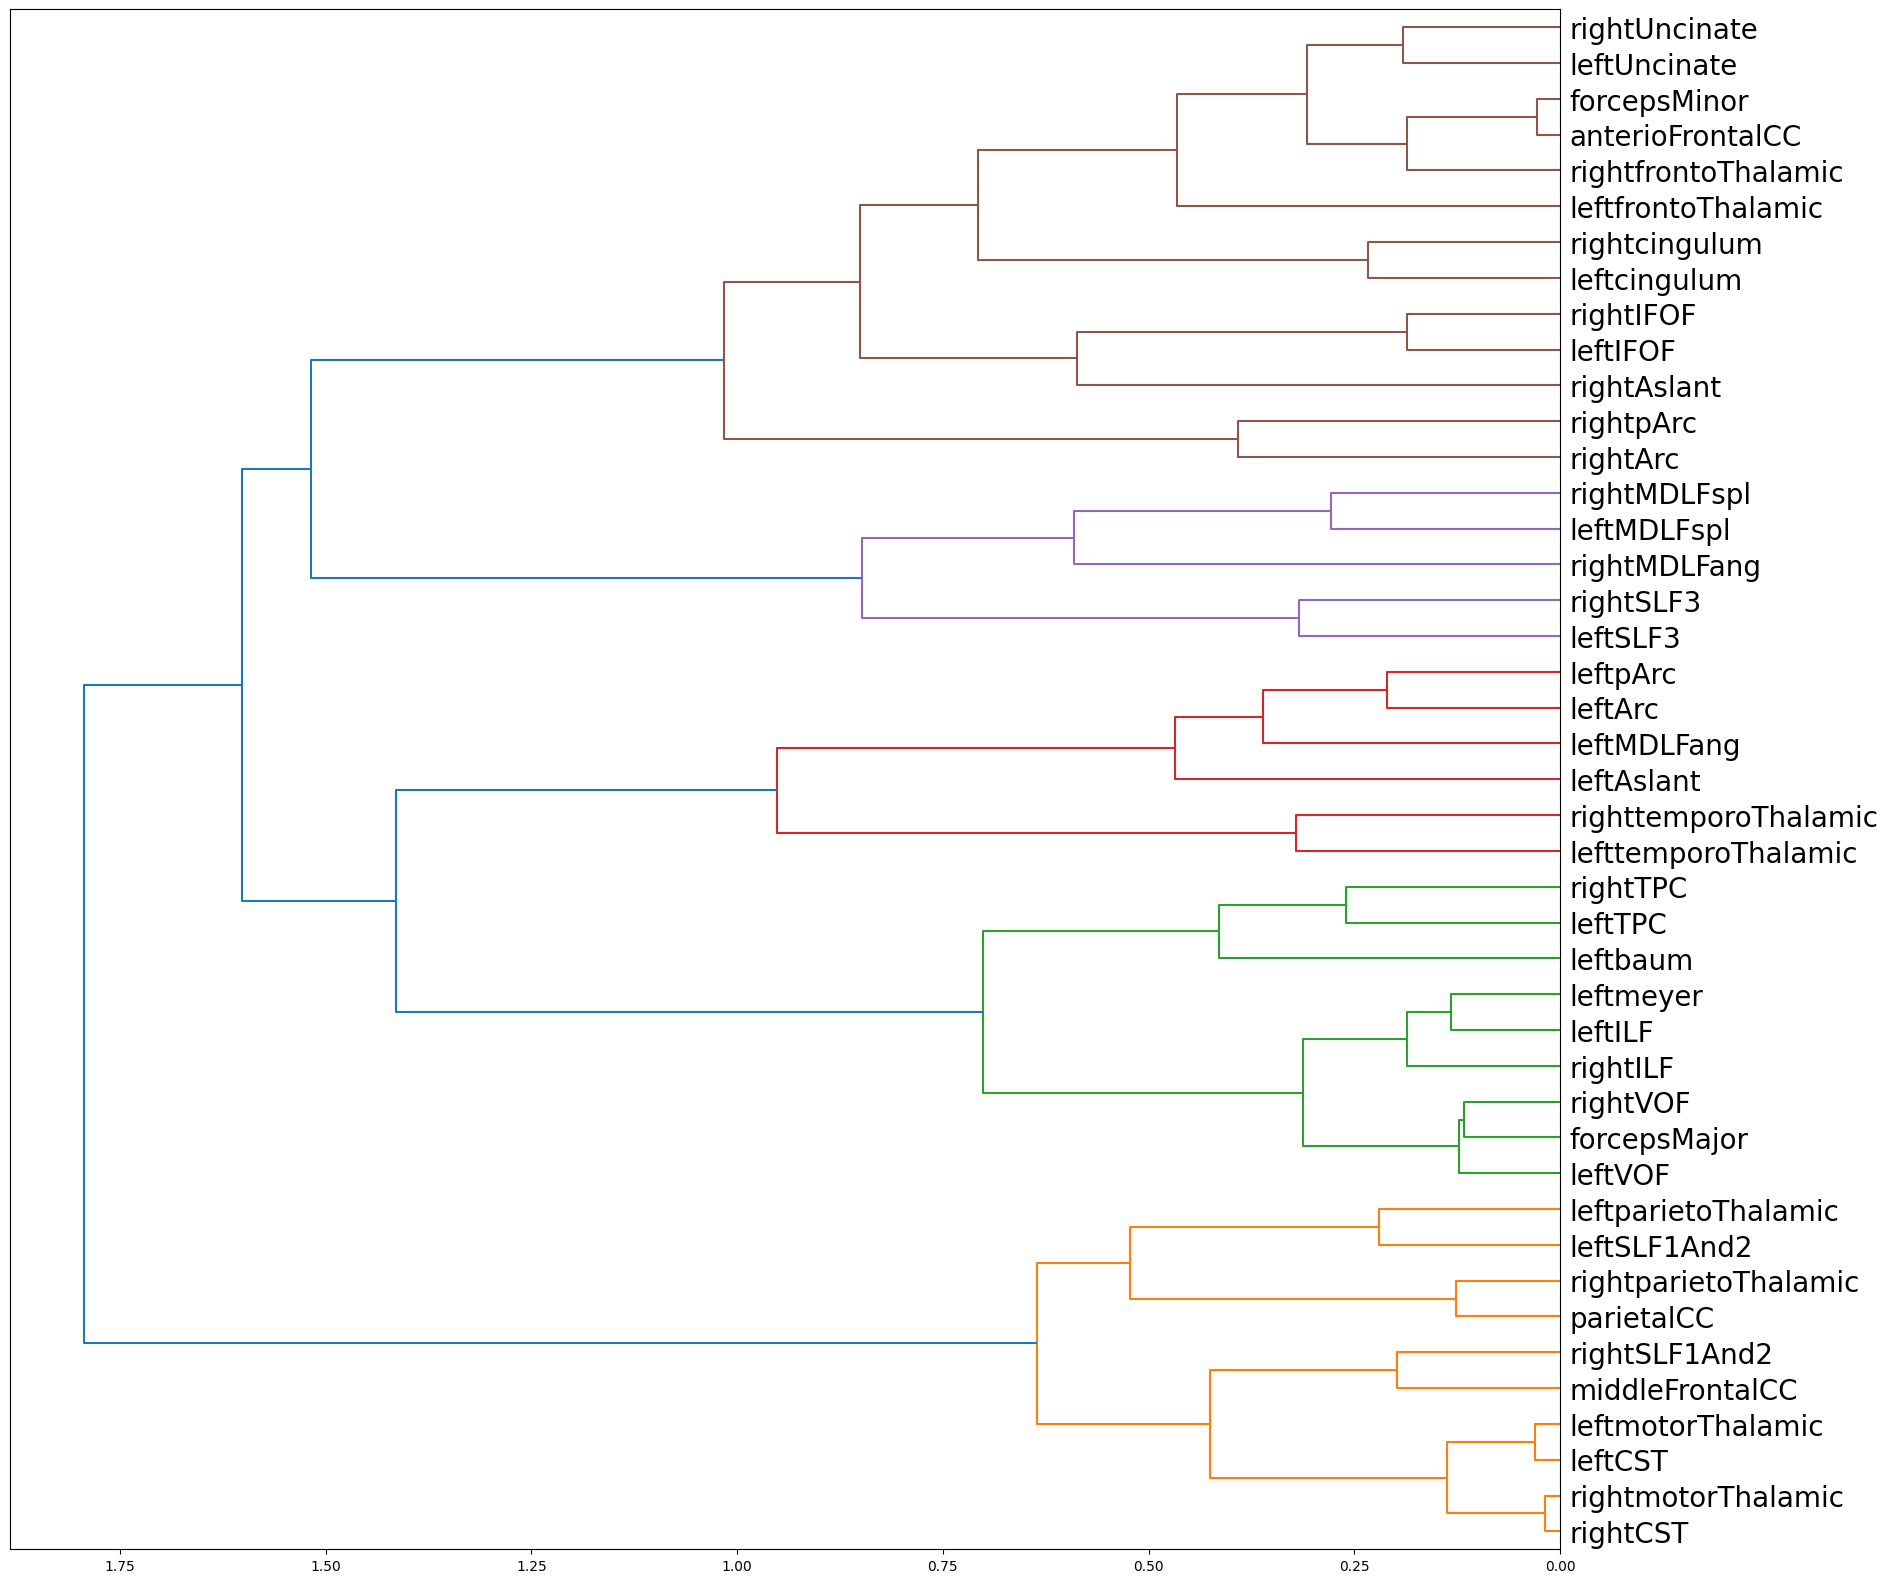

In [ ]:
# constant to choose whether to cluster by topic or endpoint ROI
TOPIC = 't'
ROI = 'r'

clusterby = ROI # CHANGE THIS!!!

# transform and clean df
if clusterby == ROI:
    pivot_df = map_corr_df.pivot(index = 'topic', columns='ROI', values='r') # pivot from long to wide
elif clusterby == TOPIC:
    pivot_df = map_corr_df.pivot(index = 'ROI', columns='topic', values='r') # pivot from long to wide
else:
    print("Error: Incorrect clustering method provided")
pivot_df_cleaned = pivot_df.dropna(axis=1) # drop cols with NA values
# note to self: pivot_df.to_csv('output.csv', index=True)

# compute correlation matrix and HCA
corr_mtrix = pivot_df_cleaned.corr(method='pearson') 

# HCA -
link_method = 'complete'
dissimilarity = 1 - corr_mtrix # distance matrix
hca = linkage(squareform(dissimilarity), link_method)

# plot dendrogram
plt.figure(figsize=(20,20)) #45, 30
dendrogram(hca, labels=corr_mtrix.columns, 
           orientation='right',
           leaf_font_size=20);
# plt.savefig('./dendro_' + link_method + '.png', 
#             bbox_inches = 'tight');
#thresh = 1.5
#plt.axhline(y=thresh, c='k')